## Notebook description: *Coconatfly_PhN_Cosine.ipynb*

This notebook performs a **clustering analysis of PhN (pharyngeal nerve) sensory axons** using the **FlyWire connectome** via the `coconatfly` R package (workflow adapted from *McKim et al. 2024*).

New coconatfly users should start with the coconatfly tutorial https://github.com/natverse/coconatfly/

### What it does (high-level)
1. **Loads a curated neuron list / annotations** from project CSV files in `PATH_input`.
2. **Defines the target PhN population** (FlyWire root IDs) and retrieves **FlyWire metadata** for those neurons.
3. **Computes output connectivity partners** (postsynaptic targets) for each neuron using `cf_partners(..., partners="outputs")`, applying a **synapse threshold** (e.g., ≥5) to focus on stronger connections.
4. Builds an output-connectivity representation and computes **pairwise cosine similarity** of output profiles.
5. Uses **hierarchical clustering** (Ward.D2) to group neurons by similarity of their downstream connectivity.
6. Produces a cosine-based clustering plot (dendrogram/heatmap view depending on settings), saves a **PDF** figure, and also plots inline.

### Key inputs
- `PhN_v1.0*.csv`: curated/annotated list of PhN neurons (contains `id` / root IDs plus annotations).
- A manually provided list of FlyWire **root IDs** (`ids_string`) used to query metadata/connectivity (here: “without putative DCSOs”).

### Key intermediate objects (as named in this notebook)
- `PhN`: curated annotation table loaded from CSV (first column renamed to `id`).
- `pharyngeal`: metadata table for the selected neurons (joined with `PhN` annotations).
- `pharyngeal_partners`: partner table from `cf_partners(..., partners="outputs")`.
- `pharyngeal$key`: connectivity-derived key used by `cf_cosine_plot(...)` for cosine similarity and clustering.

### Key outputs
- A clustering figure saved to PDF (see the plotting cell; filename includes `v`).
- Inline clustering plot for quick inspection.

### Notes / assumptions
- Connectivity is analyzed on **output synapses** (presynaptic neuron → downstream targets).
- Thresholds (partner threshold, cosine threshold, and optional filtering by total output synapses) affect which neurons/partners contribute to similarity and clustering.
- In FlyWire FAFB v783, aPhN = Accessory pharyngeal/aPharyngeal Nerve; PhN = Pharyngeal Nerve. In this analysis, the PhN consists of the stomodeal nerve (StN) and the Dorsal Cibarial Sensory Organ (DCSO), and pharyngeal nerve motor neurons (which are not included); the aPhN consists of axons of the Ventral Cibarial Sensory Organ (VCSO) and the Labral Sensory Organ (LSO). We consider the aPhN and PhN collectively as the PanPharyngeal sensory axons.

In [ ]:
# Quick notebook summary (prints what exists in the current kernel for THIS notebook)
summary_info <- list(
  paths = list(input = PATH_input, output = PATH_output),
  n_input_files = if (exists("input_files")) length(input_files) else NA_integer_,
  objects_present = c(
    PhN = exists("PhN"),
    pharyngeal = exists("pharyngeal"),
    pharyngeal_partners = exists("pharyngeal_partners")
  ),
  counts = list(
    PhN_rows = if (exists("PhN")) nrow(PhN) else NA_integer_,
    pharyngeal_rows = if (exists("pharyngeal")) nrow(pharyngeal) else NA_integer_,
    pharyngeal_partners_rows = if (exists("pharyngeal_partners")) nrow(pharyngeal_partners) else NA_integer_
  ),
  outputs = list(
    pdf_expected = if (exists("v")) paste0("./Giakoumas-et-al/output/figures/fig_2", v, ".pdf") else NA_character_
  )
)

print(summary_info)

## Output files produced by this notebook

If the output directory is writable, running the plotting cell will write:

- `./Giakoumas-et-al/output/figures/fig_2{v}.pdf`

This file contains the PhN cosine-similarity clustering plot based on **output connectivity**.


In [ ]:
#----Figure_2A-------------------------------------------------------------------
#-------------------------------------------------------------------------------
# This is the code for PhN clustering analysis, adapted from McKim et al. 2024
#-------------------------------------------------------------------------------

#-load packages-----------------------------------------------------------------
library(tidyverse)
library(coconatfly)

###general variables:-----------------------------------------------------------
set.seed(42)
options(scipen = 999)

PATH_input = "./Giakoumas-et-al/input/input_coconatfly/"
PATH_output = "./Giakoumas-et-al/output/figures/fig_2/"
version <- "1.0"  # Specify version manually

In [ ]:
input_files = list.files(path = PATH_input, full.names = FALSE, recursive = FALSE)

In [ ]:
input_files_tmp = list.files(path = paste0(PATH_input,"tmp/"),
full.names = FALSE, recursive = FALSE)
input_files = c(input_files,input_files_tmp)
v = read_delim(paste0(PATH_input,"PhN_v1.0.csv"),
col_types  =  cols(version  =  col_character()),delim  =  ";")

Warning message:
“The following named parsers don't match the column names: version”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [ ]:
v = v$version[1]

# set variables:----------------------------------------------------------------
PhN = read_delim(paste0(PATH_input,"PhN_v1.0",v,".csv"),
col_types = cols(root_id = col_character()),delim = ",")

Warning message:
“Unknown or uninitialised column: `version`.”


In [ ]:
#-------------------------------------------------------------------------------
#clustering of all endocrine cells
colnames(PhN)[1] <- 'id'
# paste0(PhNid, collapse = ",")

#obtain meta data for all pharyngeal cells

In [ ]:
#without putative DCSOs
ids_string <- paste(c(
    "720575940611959011", "720575940613004402", "720575940637896245", "720575940622198772",
    "720575940619652033", "720575940621207517", "720575940624905572", "720575940620910716",
    "720575940638357813", "720575940605161388", "720575940607166731", "720575940633579360",
    "720575940627274578", "720575940624910373", "720575940659479937", "720575940611388595",
    "720575940625471896", "720575940620528990", "720575940610897906", "720575940624724458",
    "720575940653233569", "720575940613347474", "720575940634755041", "720575940627107271",
    "720575940604355872", "720575940621106465", "720575940625941022", "720575940630574659",
    "720575940632040749", "720575940648377209", "720575940639972816", "720575940614641202",
    "720575940631205580", "720575940607152476", "720575940612256938", "720575940627989609",
    "720575940630434616", "720575940631572141", "720575940635501560", "720575940631070239",
    "720575940631462969", "720575940650760825", "720575940644676900", "720575940645493283",
    "720575940633194029", "720575940625871181", "720575940631963821", "720575940631049064",
    "720575940633895469", "720575940633129683", "720575940634085786", "720575940630654539",
    "720575940646039092", "720575940645524003", "720575940623056422", "720575940639786830",
    "720575940620983637", "720575940632743649", "720575940626311049", "720575940626396803",
    "720575940617034713", "720575940624502269", "720575940604782624", "720575940606163842",
    "720575940629887695", "720575940626767152", "720575940641265549", "720575940622144648",
    "720575940638086256", "720575940645108936", "720575940633129171", "720575940622575754",
    "720575940619316603", "720575940605682790", "720575940606239666", "720575940630806267",
    "720575940623951591", "720575940633759840", "720575940625785731"

),
    collapse = " ")

In [ ]:
# Now, retrieve metadata for all root IDs using the concatenated string
pharyngeal<- cf_meta(cf_ids(ids_string, datasets = "flywire"))

Warning message in normalizePath(python_home):
“path[1]="/Users/dimitriosgiakoumas/Library/Caches/org.R-project.R/R/reticulate/uv/cache/builds-v0/.tmp3mfdtj/bin": No such file or directory”


Error in python_config_impl(python) : 
  Error running '/Users/dimitriosgiakoumas/Library/Caches/org.R-project.R/R/reticulate/uv/cache/builds-v0/.tmp3mfdtj/bin/python': No such file.


Warning message:
“Disabling gzip/deflate encoding due to buggy libcurl 8.7.1.
You may want to update libcurl if possible.
See https://github.com/curl/curl/issues/13493.”


In [ ]:
pharyngeal= left_join(pharyngeal,PhN,by = "id")
pharyngeal$side_name_id = paste(
pharyngeal$side,
pharyngeal$name,pharyngeal$id,sep="")

In [ ]:
library(bit64)

pharyngeal_partners <- pharyngeal%>%
cf_partners(
threshold = 5,        # Minimum synapse count
partners = "outputs"  # Focus on output synapses
)

# 4. Aggregate synapse counts per neuron
output_counts <- pharyngeal_partners %>%
group_by(pre_id) %>%
summarise(output_count = sum(weight))

# 5. Convert pre_id to character for compatibility
output_counts <- output_counts %>%
mutate(pre_id = as.character(pre_id))

# 6. Join counts back to metadata
pharyngeal<- pharyngeal%>%
left_join(output_counts, by = c("id" = "pre_id")) %>%
filter(output_count >= 4)

Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:dplyr’:

    symdiff


The following object is masked from ‘package:base’:

    xor


Attaching package bit64

package:bit64 (c) 2011-2017 Jens Oehlschlaegel

creators: integer64 runif64 seq :

coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

logical operator: ! & | xor != == < <= >= >

arithmetic operator: + - * / %/% %% ^

math: sign abs sqrt log log2 log10

math: floor ceiling trunc round

querying: is.integer64 is.vector [is.atomic} [length] format print str

values: is.na is.nan is.finite is.infinite

aggregation: any all min max range sum prod

cumulation: diff cummin cummax cumsum cumprod

access: length<- [ [<- [[ [[<-

combine: c rep cbind rbind as.data.frame

WARNING don't use as subscripts

WARNING semantics differ from integer

for more help type ?bit64


Attaching package: ‘bit64’


The following object is masked from ‘package:u

In [ ]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')
pdf(
paste0("./Giakoumas-et-al/output/figures/fig_2", v, ".pdf"),
width = 15,  # Increase width further
height = 10  # Increase height further
)
options(repr.plot.res = 300)
par(mar = c(15, 20, 4, 2) + 0.1, oma = c(5, 5, 5, 5))  # Adjust margins to make space for labels
pharyngeal%>%
with(cf_cosine_plot(
key,
threshold = 1,
labRow = id,  # Use raw root IDs for labels
interactive = FALSE,
partners = "outputs",
method = "ward.D2",
cexRow = 0.2,  # Reduce font size for row labels
cexCol = 0.2   # Reduce font size for column labels
))
dev.off()

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 487/4880 neurons representing 2775/24936 synapses due to missing ids!”


pdf 
  2

Matching types across datasets. Dropping 0/4880 output partner types with total weight 0/24936

Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 487/4880 neurons representing 2775/24936 synapses due to missing ids!”


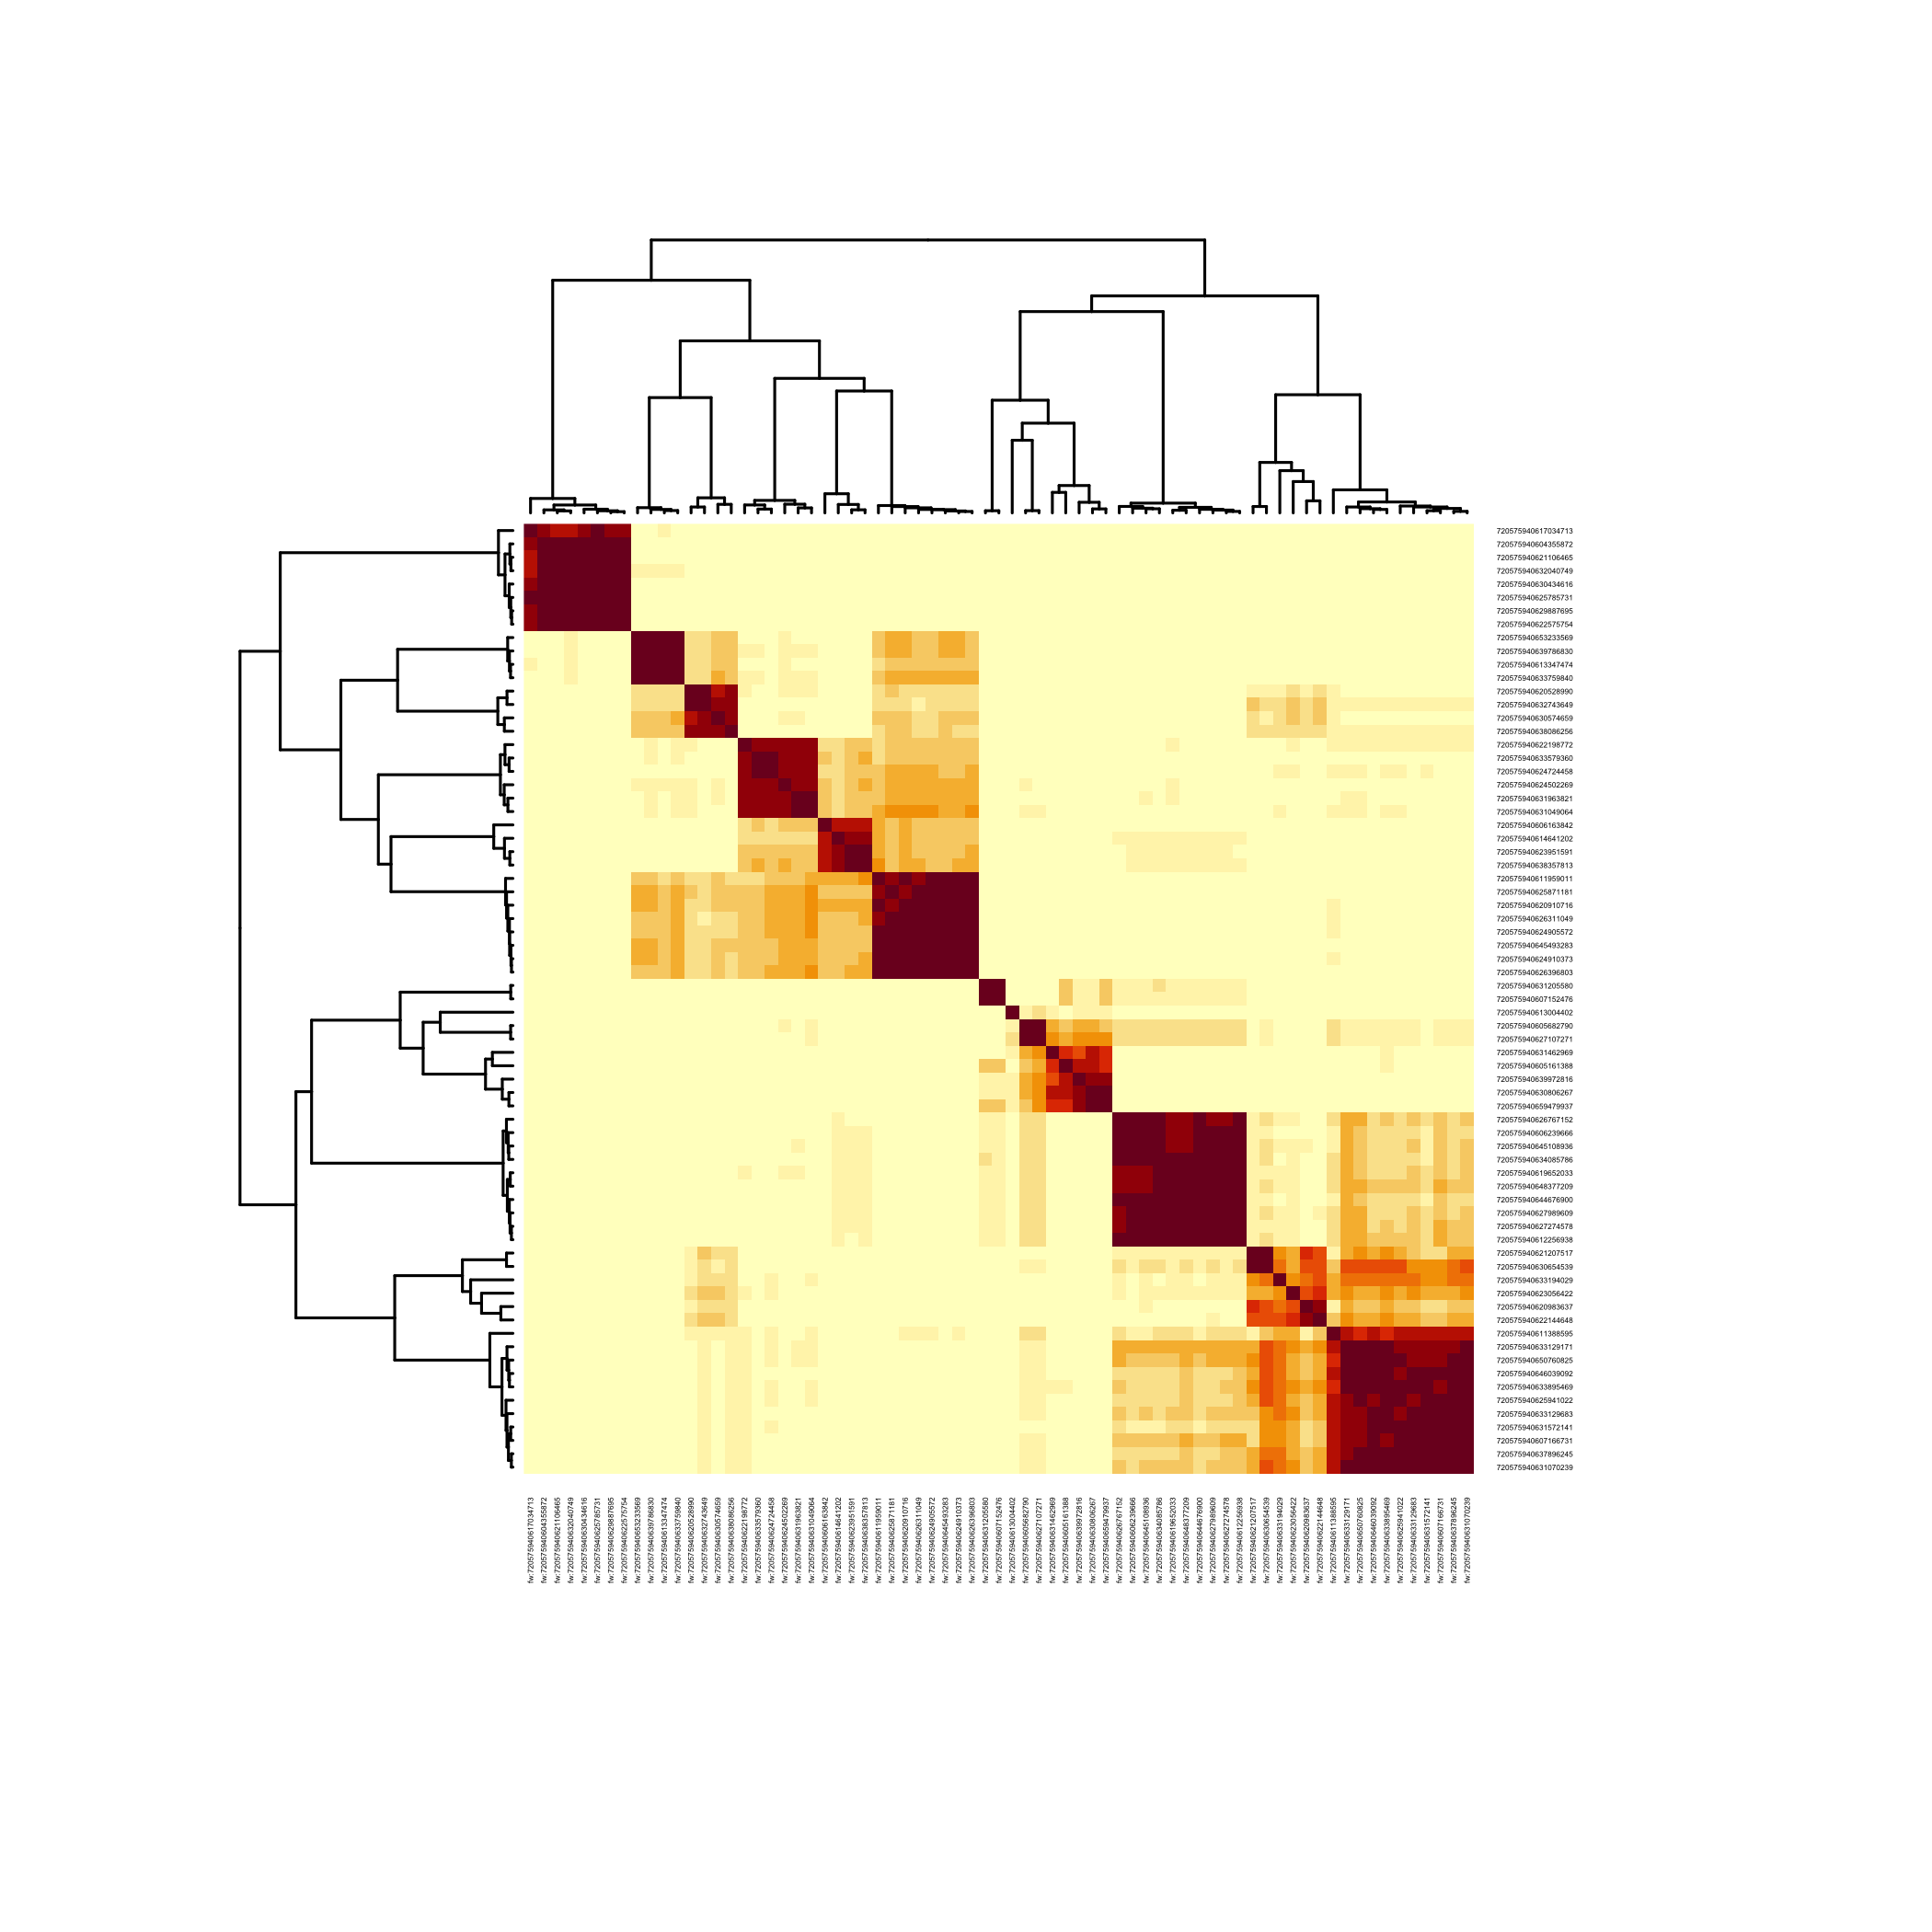

In [ ]:
# Generate the plot with corrected labels (use 'id' instead of 'side_name_id')

options(repr.plot.res = 300)
par(mar = c(15, 20, 4, 2) + 0.1, oma = c(5, 5, 5, 5))  # Adjust margins to make space for labels
pharyngeal%>%
with(cf_cosine_plot(
        key,
        threshold = 1,
        labRow = id,  # Use raw root IDs for labels
        interactive = FALSE,
        partners = "outputs",
        method = "ward.D2",
        cexRow = 0.2,  # Reduce font size for row labels
        cexCol = 0.2   # Reduce font size for column labels
))